In [56]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def import_data() -> ((np.ndarray, np.ndarray), (np.ndarray, np.ndarray)):
    return tf.keras.datasets.cifar100.load_data(label_mode="coarse")

In [57]:
(x_train, y_train), (x_test, y_test) = import_data()

#### Converting Images to Grayscale

In [58]:
def convert_to_grayscale(train, test):
    rgb_weights = [0.2989, 0.5870, 0.1140]
    gray_train = np.dot(train[:][...,:3], rgb_weights)
    gray_test = np.dot(test[:][...,:3], rgb_weights)
    return gray_train, gray_test

In [59]:
# x_train, x_test = convert_to_grayscale(x_train, x_test)

#### Increasing Constrast

In [60]:
def increase_image_contrast(image):
    xp = [0, 64, 128, 192, 255]
    fp = [0, 16, 128, 240, 255]
    x = np.arange(256)
    table = np.interp(x, xp, fp).astype('uint8')
    return cv2.LUT(image, table)

def increase_all_contrast(train, test):
    new_train = np.copy(train)
    new_test = np.copy(test)
    for i in range(len(train)):
        new_train[i] = increase_image_contrast(train[i])
    for i in range(len(test)):
        new_test[i] = increase_image_contrast(test[i])
    return new_train, new_test

In [61]:
x_train, x_test = increase_all_contrast(x_train, x_test)

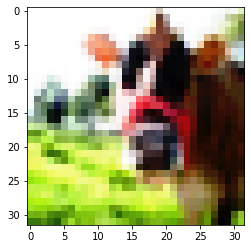

In [62]:
plt.imshow(x_train[0])

#### Flattening the Images

In [63]:
def flatten_data(x_train, y_train, x_test, y_test):
    new_image_shape = 1
    for dim in range(1, len(x_train.shape)):
        new_image_shape *= x_train.shape[dim]
        
    flat_x_train = x_train.reshape((x_train.shape[0], new_image_shape))
    flat_y_train = np.ravel(y_train)
    
    flat_x_test = x_test.reshape((x_test.shape[0], new_image_shape))
    flat_y_test = np.ravel(y_test)
    return flat_x_train, flat_y_train, flat_x_test, flat_y_test

In [64]:
x_train, y_train, x_test, y_test = flatten_data(x_train, y_train, x_test, y_test)

In [65]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs=-1, verbose=1, bootstrap=False, max_features='log2')
model.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.8s finished


RandomForestClassifier(bootstrap=False, max_features='log2', n_jobs=-1,
                       verbose=1)

In [66]:
model.score(x_test, y_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


0.3405